In [1]:
from XRDXRFutils import DataXRD, DatabaseXRD, SpectraXRD, GaussNewton

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from glob import glob
import re

# Read phase database

In [2]:
#path_phases = 'Database'
path_phases = '../../dati/Database/'
database = DatabaseXRD().read_cifs(path_phases)
phase_chosen = database['Calcite'][0]
calibration_right = np.array([-741.96144778, 2803.29875555, 31.09111973])

# Create experimental spectrum

In [3]:
min_theta = 16
max_theta = 42
min_intensity = None

gamma_experimental = 1.2
sigma_experimental = 0.3
shift_angle = -0.4

g_experimental = sp.optimize.newton(lambda x: GaussNewton.w(x) - gamma_experimental, x0 = gamma_experimental)
sigma2_experimental = sigma_experimental**2
tau_experimental = sp.optimize.newton(lambda x: GaussNewton.u(x) - sigma2_experimental, x0 = sigma2_experimental)

print(f'g of experimental spectrum: {g_experimental}')
print(f'Gamma of experimental spectrum: {gamma_experimental}')
print(f'Tau of experimental spectrum: {tau_experimental}')
print(f'Sigma of experimental spectrum: {np.sqrt(GaussNewton.u(tau_experimental))}')
print(f'Sigma^2 of experimental spectrum: {GaussNewton.u(tau_experimental)}')

spectrum_dummy = SpectraXRD().from_array(np.ones(1280))
spectrum_dummy.opt = calibration_right
fit_dummy = GaussNewton(phase_chosen, spectrum_dummy, min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity)
fit_dummy.tau = np.full_like(fit_dummy.tau, tau_experimental)
fit_dummy.mu = fit_dummy.get_theta(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity)[0] + shift_angle
spectrum_sample = SpectraXRD().from_array(fit_dummy.z())
spectrum_sample.opt = calibration_right
spectrum_sample.intensity = fit_dummy.z() / fit_dummy.z().max()

g of experimental spectrum: 0.9916666666666666
Gamma of experimental spectrum: 1.2
Tau of experimental spectrum: 0.29999999999999905
Sigma of experimental spectrum: 0.29999999999999905
Sigma^2 of experimental spectrum: 0.08999999999999943


# Gauss-Newton

In [4]:
fit_sample = GaussNewton(phase_chosen, spectrum_sample, min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity)
fit_sample.I /= gamma_experimental
opt_initial = fit_sample.opt.copy()

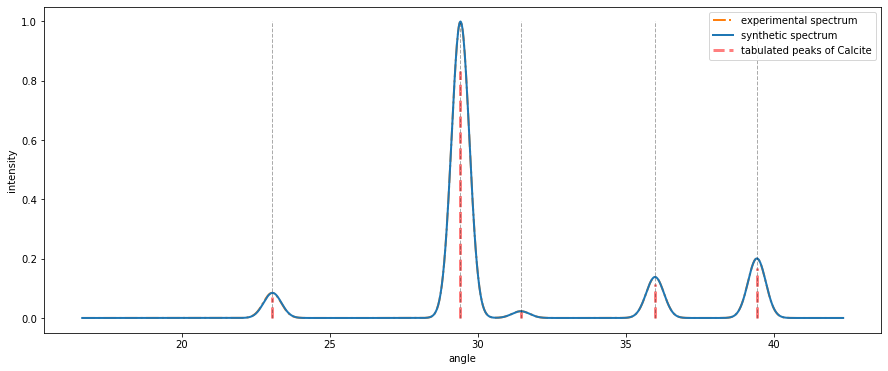

Fit error = 0.00035678250859694563
Initial calibration parameters =	[-741.96144778 2803.29875555   31.09111973]
Fitted calibration parameters =	[-722.31541203 2801.68931341   31.09111973]
gamma =	[[1.19917736 1.20001898 1.19999801 1.20000103 1.19999804]]
tau =	[[ 0.3009902   0.30031028 -0.30016679  0.2998336   0.29957973]]
sigma2 =	[[0.0905951  0.09018627 0.0901001  0.08990019 0.08974802]]
sigma =	[[0.3009902  0.30031028 0.30016679 0.2998336  0.29957973]]


In [7]:
fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(fit_sample.theta, fit_sample.intensity, ls = '-.', lw = 2, c = 'tab:orange', label = 'experimental spectrum')
ax.plot(fit_sample.theta, fit_sample.z(), ls = '-', lw = 2, c = 'tab:blue', label = 'synthetic spectrum')
ax.vlines(fit_sample.mu, 0, fit_sample.I, 'r', alpha = 0.5, ls = '--', lw = 3, label = 'tabulated peaks of ' + phase_chosen['_chemical_name_mineral'])
ax.vlines(fit_sample.mu, 0, 1, 'k', alpha = 0.33, ls = '--', lw = 1)
ax.set_xlabel('angle')
ax.set_ylabel('intensity')
ax.legend()
#ax.set_xlim(21, 41)
#ax.set_ylim(0, 1)
plt.show()

print(f'Fit error = {fit_sample.fit_error()}')
print(f'Initial calibration parameters =\t{opt_initial}')
print(f'Fitted calibration parameters =\t{fit_sample.opt}')
print(f'gamma =\t{fit_sample.gamma}')
print(f'tau =\t{fit_sample.tau}')
print(f'sigma2 =\t{fit_sample.sigma2}')
print(f'sigma =\t{np.sqrt(fit_sample.sigma2)}')

In [24]:
#fit_sample.fit(a = True)
#fit_sample.fit(a = True, beta = True)
#fit_sample.fit(gamma = True, sigma = True)
#fit_sample.fit(gamma = True)
#fit_sample.fit(sigma = True)
#fit_sample.fit(a = True, s = True, beta = True, sigma = True)
#fit_sample.fit(a = True, beta = True, sigma = True)
#fit_sample.fit(beta = True, sigma = True)
#fit_sample.fit(beta = True, gamma = True, sigma = True)
fit_sample.fit(a = True, s = True, gamma = True, sigma = True)
#fit_sample.fit(a = True, beta = True, gamma = True, sigma = True)
#fit_sample.fit(a = True, s = True, beta = True, gamma = True, sigma = True)

In [6]:
fit_sample.fit_cycle(max_steps = 16, a = True, s = True, gamma = True, sigma = True)

# Manipulate the fitting spectrum

In [44]:
# Set right calibration
fit_sample.opt = calibration_right + np.array([0, 0, -shift_angle])

In [122]:
# Set right gamma
fit_sample.g = np.full_like(fit_sample.g, g_experimental)

In [115]:
# Set right sigma
fit_sample.tau = np.full_like(fit_sample.g, tau_experimental)